In [2]:
import sys
sys.path.append("/Users/CC/anaconda/lib/python2.7/site-packages")

import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import mode
from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
from sklearn.cross_validation import train_test_split as sk_split
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression as LogReg
import datetime
import time
%matplotlib inline

## Part 1 - Cleaning Data
by Zainab Doctor

In [148]:
#Read in data
shots = pd.read_csv('shot_logs.csv', delimiter=',')

print 'dimensions of dataset:', shots.shape
shots.head(3)


dimensions of dataset: (128069, 21)


,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148


In [149]:
data = shots[['GAME_ID', 'LOCATION', 'SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'SHOT_DIST', 
              'SHOT_RESULT', 'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST', 'FGM', 'PTS', 'player_id']]

print data.shape

(128069, 13)


In [150]:
data = data[data['SHOT_CLOCK'].notnull()]
#lose 5567 entries

data = data[data['SHOT_CLOCK'] > 1] #results in loss of 1004 shots taken with <1 second on the shot clock

#data = data[data['GAME_CLOCK'] != '0:00'] filtering based on GAME_CLOCK doesn't result in any further loss of entries

#Convert game clock to seconds
T = data['GAME_CLOCK'].values
gameclock_seconds = []

for i in range(T.shape[0]):
    x = T[i].split(':')
    gameclock_seconds.append(60*int(x[0]) + int(x[1]))

data['GAME_CLOCK'] = gameclock_seconds

data = data[data['GAME_CLOCK'] > 1] # results in loss of 2 entries



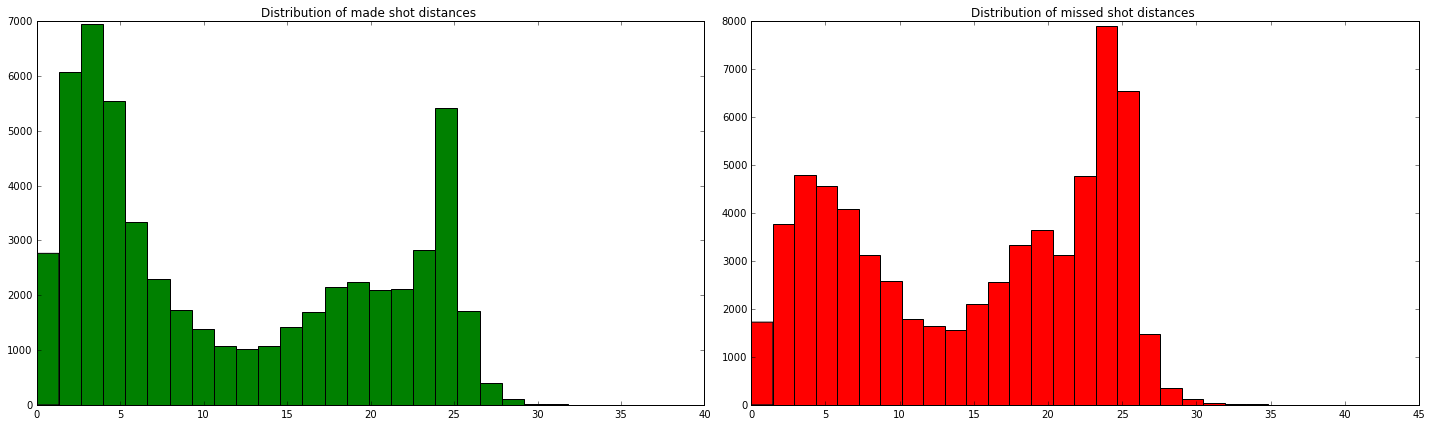

In [151]:
#Plotting shot distances based on whether they were made or missed
subset = data[data['SHOT_RESULT'] == 'made']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.hist(subset['SHOT_DIST'],30, color='green')
ax1.set_title('Distribution of made shot distances ')

subset = data[data['SHOT_RESULT'] == 'missed']
ax2.hist(subset['SHOT_DIST'],30, color='red')
ax2.set_title('Distribution of missed shot distances ')

plt.tight_layout()    
plt.show()

## Part 2 - Filtering Data Based on Shots Taken by Players
by Hubert Huang

number of unique player ID: 281
number of unique game ID: 896


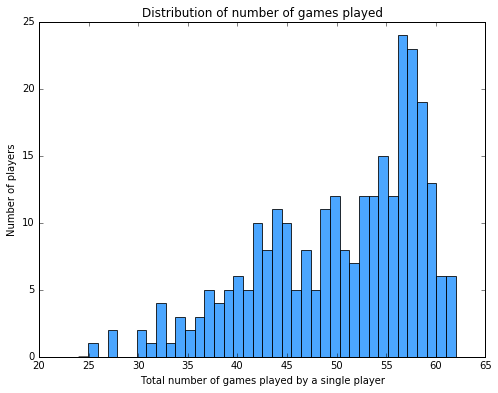

In [152]:
# There are actually data from 281 players
print 'number of unique player ID:', np.unique(data['player_id'].values).shape[0] 
# print 'number of unique player names:', np.unique(data['player_name'].values).shape[0]
player_id = np.unique(data['player_id'].values)
# player_name = np.unique(data['player_name'].values)

# How many unique games are there (should there be 30 * 82 / 2 = 1230 games?)
# Several players may share the same game ID (becuase they all played that night)
print 'number of unique game ID:', np.unique(data['GAME_ID'].values).shape[0]

# Create a dictionary where player_id is the key and all associated unique game IDs are the values
gameID_by_player = {}
for player in player_id:
    gameID_by_player[player] = np.unique(data[data['player_id'] == player]['GAME_ID'])

# games_per_player, in same order as player_id, contains the number of games played by per player
games_per_player = np.array([gameID_by_player[player].shape[0] for player in player_id])
    
# Plot the distribution of number of games played by all players    
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

bin_max = games_per_player.max() + 1
bin_min = games_per_player.min() - 1
bins = bin_max - bin_min + 1

ax.hist(games_per_player, bins = bins, range = (bin_min, bin_max), color='dodgerblue', alpha = 0.8)
ax.set_title('Distribution of number of games played')
ax.set_xlabel('Total number of games played by a single player')
ax.set_ylabel('Number of players')
plt.show()

In [153]:
# shots_by_player is a dictionary where player_id is the key and number of shots made per game are the values
# shots_by_player is in the same order as gameID_by_player
shots_by_player = {}
for player in player_id:
    shots_by_player[player] = np.array([data[(data['player_id'] == player) & (data['GAME_ID'] == game)].shape[0] 
                                        for game in gameID_by_player[player]])

How many unique shot series do we have?  14165


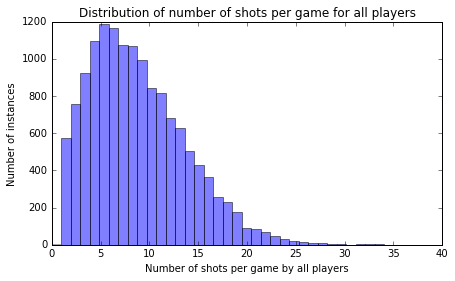

Shoot series with length smaller than 4 comprises: 15.9% of all shot series


In [154]:
# I want to come up with a better way to visualize the data above. (For individual players)
# However, for now:

# Make an array combining number of shots made per game by all the players
shots_by_all_players = np.array([]).astype(int)
for player in player_id:
    shots_by_all_players = np.append(shots_by_all_players, shots_by_player[player])

# Get the number of unique shot series
print 'How many unique shot series do we have? ', shots_by_all_players.shape[0]
# print sum(games_per_player) # Sanity chekc also 14165

fig, ax = plt.subplots(1, 1, figsize = (7,4))

bin_max = shots_by_all_players.max() + 1
bin_min = shots_by_all_players.min() - 1
bins = bin_max - bin_min + 1

ax.hist(shots_by_all_players, bins = bins, range = [bin_min, bin_max], color = 'b', alpha = 0.5)

ax.set_title('Distribution of number of shots per game for all players')
ax.set_xlabel('Number of shots per game by all players')
ax.set_ylabel('Number of instances')
plt.show()

print 'Shoot series with length smaller than 4 comprises: {:.1f}% of all shot series'.format(
    float(shots_by_all_players[shots_by_all_players < 4].shape[0]) / float(shots_by_all_players.shape[0]) * 100)
# We will throw away 15.9% of shot series

In [155]:
# Make a new column that contains the length of the shot series that the shot is associated with
# This will be useful for filtering purposes

## Testing
# print gameID_by_player[708]
# print int(shots_by_player[708][np.where(gameID_by_player[708] == 21400902)])

# Actual execution
data['shot_series_length'] = [int(shots_by_player[data['player_id'].iloc[i]][np.where(gameID_by_player[data['player_id'].iloc[i]] == data['GAME_ID'].iloc[i])]) for i in range(data.shape[0])]

In [156]:
# Sanity check
data.iloc[:20]

,GAME_ID,LOCATION,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,SHOT_RESULT,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id,shot_series_length
0,21400899,A,1,1,69,10.8,7.7,made,101187,1.3,1,2,203148,8
1,21400899,A,2,1,14,3.4,28.2,missed,202711,6.1,0,0,203148,8
3,21400899,A,4,2,707,10.3,17.2,missed,203900,3.4,0,0,203148,8
4,21400899,A,5,2,634,10.9,3.7,missed,201152,1.1,0,0,203148,8
5,21400899,A,6,2,495,9.1,18.4,missed,101114,2.6,0,0,203148,8
6,21400899,A,7,4,615,14.5,20.7,missed,101127,6.1,0,0,203148,8
7,21400899,A,8,4,480,3.4,3.5,made,203486,2.1,1,2,203148,8
8,21400899,A,9,4,314,12.4,24.6,missed,202721,7.3,0,0,203148,8
9,21400890,H,1,2,692,17.4,22.4,missed,201961,19.8,0,0,203148,4
10,21400890,H,2,2,390,16.0,24.5,missed,202391,4.7,0,0,203148,4


In [157]:
# Now filter out all the shot series shorter than 4
print data.shape[0]

data = data[data['shot_series_length'] > 4]
print data.shape[0] #results in loss of 10k or so shots

data.iloc[:100]

121172
111945


,GAME_ID,LOCATION,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,SHOT_RESULT,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id,shot_series_length
0,21400899,A,1,1,69,10.8,7.7,made,101187,1.3,1,2,203148,8
1,21400899,A,2,1,14,3.4,28.2,missed,202711,6.1,0,0,203148,8
3,21400899,A,4,2,707,10.3,17.2,missed,203900,3.4,0,0,203148,8
4,21400899,A,5,2,634,10.9,3.7,missed,201152,1.1,0,0,203148,8
5,21400899,A,6,2,495,9.1,18.4,missed,101114,2.6,0,0,203148,8
6,21400899,A,7,4,615,14.5,20.7,missed,101127,6.1,0,0,203148,8
7,21400899,A,8,4,480,3.4,3.5,made,203486,2.1,1,2,203148,8
8,21400899,A,9,4,314,12.4,24.6,missed,202721,7.3,0,0,203148,8
14,21400859,A,1,1,48,6.8,22.8,missed,203935,5.3,0,0,203148,5
15,21400859,A,2,2,638,6.4,24.7,made,203923,5.6,1,3,203148,5


number of unique player ID: 280


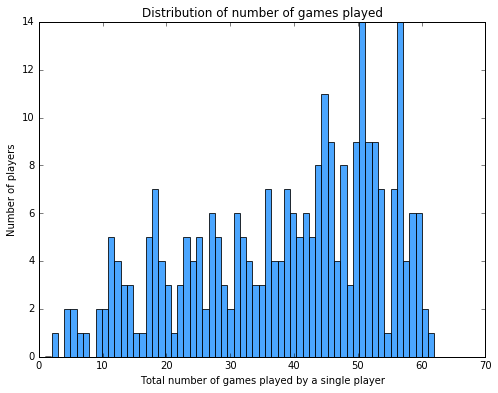

In [158]:
# Did any players drop out after this?

# There are still 280 players. Only one dropped out.
print 'number of unique player ID:', np.unique(data['player_id'].values).shape[0] 

player_id = np.unique(data['player_id'].values)

# Create a dictionary where player_id is the key and all associated unique game IDs are the values
gameID_by_player = {}
for player in player_id:
    gameID_by_player[player] = np.unique(data[data['player_id'] == player]['GAME_ID'])

# games_per_player, in same order as player_id, contains the number of games played by per player
games_per_player = np.array([gameID_by_player[player].shape[0] for player in player_id])
    
# Plot the distribution of number of games played by all players    
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

bin_max = games_per_player.max() + 1
bin_min = games_per_player.min() - 1
bins = bin_max - bin_min + 1

ax.hist(games_per_player, bins = bins, range = (bin_min, bin_max), color='dodgerblue', alpha = 0.8)
ax.set_title('Distribution of number of games played')
ax.set_xlabel('Total number of games played by a single player')
ax.set_ylabel('Number of players')
plt.show()

### Should we consider throwing away players with too few shot series because they do not have representative sample size?
### Let's leave it like this and move on for now

## Part 3a - Calculating Make and Miss Streaks
by Bailey Liao


In [159]:
# shots_by_player is a dictionary where player_id is the key and number of shots made per game are the values
# shots_by_player is in the same order as gameID_by_player
shots_by_player = {}
for player in player_id:
    shots_by_player[player] = np.array([data[(data['player_id'] == player) & (data['GAME_ID'] == game)].shape[0] 
                                        for game in gameID_by_player[player]])

How many unique shot series do we have?  10821


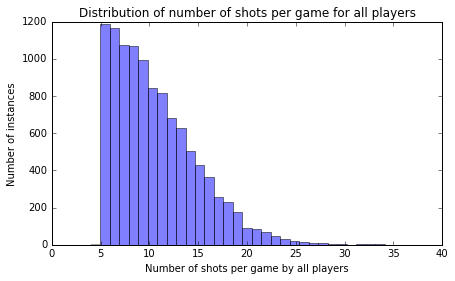

Shoot series with length smaller than 4 comprises: 0.0% of all shot series


In [160]:
# I want to come up with a better way to visualize the data above. (For individual players)
# However, for now:

# Make an array combining number of shots made per game by all the players
shots_by_all_players = np.array([]).astype(int)
for player in player_id:
    shots_by_all_players = np.append(shots_by_all_players, shots_by_player[player])

# Get the number of unique shot series
print 'How many unique shot series do we have? ', shots_by_all_players.shape[0]
# print sum(games_per_player) # Sanity chekc also 14165

fig, ax = plt.subplots(1, 1, figsize = (7,4))

bin_max = shots_by_all_players.max() + 1
bin_min = shots_by_all_players.min() - 1
bins = bin_max - bin_min + 1

ax.hist(shots_by_all_players, bins = bins, range = [bin_min, bin_max], color = 'b', alpha = 0.5)

ax.set_title('Distribution of number of shots per game for all players')
ax.set_xlabel('Number of shots per game by all players')
ax.set_ylabel('Number of instances')
plt.show()

print 'Shoot series with length smaller than 4 comprises: {:.1f}% of all shot series'.format(
    float(shots_by_all_players[shots_by_all_players < 4].shape[0]) / float(shots_by_all_players.shape[0]) * 100)
# We will throw away 15.9% of shot series

In [161]:
# Make a new column that contains the length of the shot series that the shot is associated with
# This will be useful for filtering purposes

## Testing
# print gameID_by_player[708]
# print int(shots_by_player[708][np.where(gameID_by_player[708] == 21400902)])

# Actual execution
data['shot_series_length'] = [int(shots_by_player[data['player_id'].iloc[i]][np.where(gameID_by_player[data['player_id'].iloc[i]] 
                                                                                      == data['GAME_ID'].iloc[i])]) for i in range(data.shape[0])]

In [162]:
# Sanity check
data.iloc[:20]

,GAME_ID,LOCATION,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,SHOT_RESULT,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id,shot_series_length
0,21400899,A,1,1,69,10.8,7.7,made,101187,1.3,1,2,203148,8
1,21400899,A,2,1,14,3.4,28.2,missed,202711,6.1,0,0,203148,8
3,21400899,A,4,2,707,10.3,17.2,missed,203900,3.4,0,0,203148,8
4,21400899,A,5,2,634,10.9,3.7,missed,201152,1.1,0,0,203148,8
5,21400899,A,6,2,495,9.1,18.4,missed,101114,2.6,0,0,203148,8
6,21400899,A,7,4,615,14.5,20.7,missed,101127,6.1,0,0,203148,8
7,21400899,A,8,4,480,3.4,3.5,made,203486,2.1,1,2,203148,8
8,21400899,A,9,4,314,12.4,24.6,missed,202721,7.3,0,0,203148,8
14,21400859,A,1,1,48,6.8,22.8,missed,203935,5.3,0,0,203148,5
15,21400859,A,2,2,638,6.4,24.7,made,203923,5.6,1,3,203148,5


number of unique player ID: 280


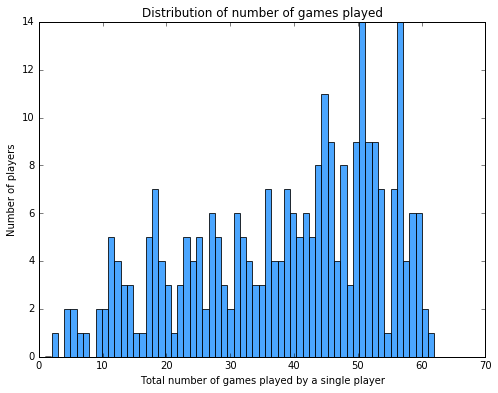

In [163]:

# Did any players drop out after this?

# There are still 280 players. Only one dropped out.
print 'number of unique player ID:', np.unique(data['player_id'].values).shape[0] 

player_id = np.unique(data['player_id'].values)

# Create a dictionary where player_id is the key and all associated unique game IDs are the values
gameID_by_player = {}
for player in player_id:
    gameID_by_player[player] = np.unique(data[data['player_id'] == player]['GAME_ID'])

# games_per_player, in same order as player_id, contains the number of games played by per player
games_per_player = np.array([gameID_by_player[player].shape[0] for player in player_id])
    
# Plot the distribution of number of games played by all players    
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

bin_max = games_per_player.max() + 1
bin_min = games_per_player.min() - 1
bins = bin_max - bin_min + 1

ax.hist(games_per_player, bins = bins, range = (bin_min, bin_max), color='dodgerblue', alpha = 0.8)
ax.set_title('Distribution of number of games played')
ax.set_xlabel('Total number of games played by a single player')
ax.set_ylabel('Number of players')
plt.show()

### Should we consider throwing away players with too few shot series because they do not have representative sample size?
### Let's leave it like this and move on for now

In [164]:
# Create new dataframe so that gameID is ordered numerically
final_df = pd.DataFrame(columns=data.columns)
final_df['MAKE_STREAK'] = []
final_df.head()

#iterate through data grouped by gameid
for _, sub_df in data.groupby('GAME_ID'):
    makestreak = []
    count = 0
    for _, row in sub_df.iterrows():
        if (row['SHOT_RESULT'] == 'made'):
            count += 1
            makestreak.append(count)
        else:
            count = 0
            makestreak.append(count)
    sub_df['MAKE_STREAK'] = makestreak
    final_df = final_df.append(sub_df, ignore_index=True)
    
final_df.head()

/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,GAME_ID,LOCATION,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,SHOT_RESULT,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id,shot_series_length,MAKE_STREAK
0,21400001.0,H,1.0,1.0,607.0,11.3,3.6,made,202696.0,1.7,1.0,2.0,201600.0,10.0,1.0
1,21400001.0,H,2.0,1.0,579.0,13.0,0.9,missed,203124.0,2.0,0.0,0.0,201600.0,10.0,0.0
2,21400001.0,H,3.0,1.0,435.0,11.5,0.8,made,202699.0,2.6,1.0,2.0,201600.0,10.0,1.0
3,21400001.0,H,4.0,1.0,314.0,21.6,3.4,missed,203095.0,1.5,0.0,0.0,201600.0,10.0,0.0
4,21400001.0,H,5.0,1.0,112.0,15.9,2.6,made,203473.0,4.5,1.0,2.0,201600.0,10.0,1.0


In [165]:
final_df2 = pd.DataFrame(columns=final_df.columns)
final_df2['MISS_STREAK'] = []
final_df2.head()

for _, sub_df in final_df.groupby('GAME_ID'):
    missstreak = []
    count = 0
    for _, row in sub_df.iterrows():
        if (row['SHOT_RESULT'] == 'missed'):
            count += 1
            missstreak.append(count)
        else:
            count = 0
            missstreak.append(count)
    sub_df['MISS_STREAK'] = missstreak
    final_df2 = final_df2.append(sub_df, ignore_index=True)
    
final_df2.head(20)

/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,GAME_ID,LOCATION,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,SHOT_RESULT,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id,shot_series_length,MAKE_STREAK,MISS_STREAK
0,21400001.0,H,1.0,1.0,607.0,11.3,3.6,made,202696.0,1.7,1.0,2.0,201600.0,10.0,1.0,0.0
1,21400001.0,H,2.0,1.0,579.0,13.0,0.9,missed,203124.0,2.0,0.0,0.0,201600.0,10.0,0.0,1.0
2,21400001.0,H,3.0,1.0,435.0,11.5,0.8,made,202699.0,2.6,1.0,2.0,201600.0,10.0,1.0,0.0
3,21400001.0,H,4.0,1.0,314.0,21.6,3.4,missed,203095.0,1.5,0.0,0.0,201600.0,10.0,0.0,1.0
4,21400001.0,H,5.0,1.0,112.0,15.9,2.6,made,203473.0,4.5,1.0,2.0,201600.0,10.0,1.0,0.0
5,21400001.0,H,6.0,1.0,75.0,24.0,2.7,made,203473.0,1.7,1.0,2.0,201600.0,10.0,2.0,0.0
6,21400001.0,H,7.0,2.0,647.0,22.6,1.2,made,202696.0,3.6,1.0,2.0,201600.0,10.0,3.0,0.0
7,21400001.0,H,8.0,2.0,361.0,23.1,2.3,made,203124.0,2.1,1.0,2.0,201600.0,10.0,4.0,0.0
8,21400001.0,H,9.0,3.0,659.0,8.4,3.6,missed,202696.0,2.2,0.0,0.0,201600.0,10.0,0.0,1.0
9,21400001.0,H,10.0,4.0,157.0,23.6,0.6,made,203473.0,1.4,1.0,2.0,201600.0,10.0,1.0,0.0


## Part 3b - Analysis of Top 5 Players
by Zecai Liang

Based on the filtered data:
1. Generate metrics to evaluate the player's performance (1) PPG = points per game (2) FG% = FGM/FGA = field goals made per game/field goals attempted per game
2. Identify top-5 players* under each criteria, compare between the two different versions of Top 5 lists.
3. For each version of the top-5 players, visualize: (1)the distribution of shot distance among shot_made and shot_missed; (2) number of game played; (3) number of shots made per game; (4) number of shots attempted per game

(* could easily be changed to "Top n Players" with customized parameter ``top_number``, if necessary)

?? Questions for Teammates:
1. When average PPG or FG% among all the games for individual players, is it proper to use mean? 
It may be biased unless we check the distribution of each player.
2. The top-5 list coming from the two criteria are non-overlapping. How do we choose?

In [166]:
data.head(5)

,GAME_ID,LOCATION,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,SHOT_RESULT,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id,shot_series_length
0,21400899,A,1,1,69,10.8,7.7,made,101187,1.3,1,2,203148,8
1,21400899,A,2,1,14,3.4,28.2,missed,202711,6.1,0,0,203148,8
3,21400899,A,4,2,707,10.3,17.2,missed,203900,3.4,0,0,203148,8
4,21400899,A,5,2,634,10.9,3.7,missed,201152,1.1,0,0,203148,8
5,21400899,A,6,2,495,9.1,18.4,missed,101114,2.6,0,0,203148,8


In [167]:
# set "Top n Player" number
top_number = 5

In [168]:
### ------------------------------------ 1. Generating Metrics ---------------------------------

# group data by player_id, then by game_id
player_game_group = data.groupby(["player_id","GAME_ID"])

   player_id   GAME_ID  PTS
0        708  21400006   10
1        708  21400033   14
2        708  21400044    6
3        708  21400060    2
4        708  21400090    4
   player_id        PTS
0        708   7.030303
1        977  16.352941
2       1495  11.196078
3       1713   6.500000
4       1717  13.894737

Top 5 Players by PPG criteria:
   index  player_id        PTS
0     27       2544  19.803922
1    132     201939  19.491228
2    105     201566  19.444444
3     28       2546  18.789474
4    187     202691  18.543860


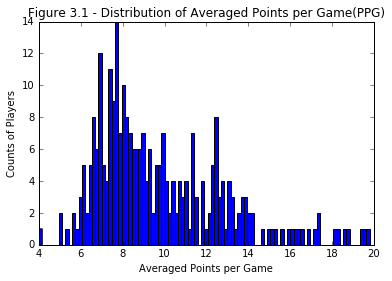

In [169]:
## ------------------------------------ Criteria 1: PPG ----------------------------------------

# points for each game of each player
player_game_ppg = player_game_group["PTS"].sum().reset_index()
print player_game_ppg.head()

# average points among games for each player 
player_ppg = player_game_ppg.groupby("player_id")["PTS"].mean().reset_index()
print player_ppg.head()

# select top n players by PPG
player_ppg_top = player_ppg.sort_values(by="PTS", ascending=False).reset_index()
print "\n", "Top %d Players by PPG criteria:" % top_number
print player_ppg_top.head(int(top_number))

# visualize the distribution of PPG for all the players
plt.hist(player_ppg_top["PTS"], bins=100)
plt.title("Figure 3.1 - Distribution of Averaged Points per Game(PPG)")
plt.xlabel("Averaged Points per Game")
plt.ylabel("Counts of Players")
plt.show()

   player_id   GAME_ID       FG%
0        708  21400006  0.625000
1        708  21400033  0.500000
2        708  21400044  0.375000
3        708  21400060  0.142857
4        708  21400090  0.250000
   player_id       FG%
0        708  0.461204
1        977  0.387361
2       1495  0.497707
3       1713  0.353841
4       1717  0.470222

Top 5 Players by FG criteria:
   index  player_id       FG%
0    124     201599  0.710055
1     13       2199  0.692956
2      6       1889  0.650072
3    137     201949  0.649858
4    246     203486  0.622819


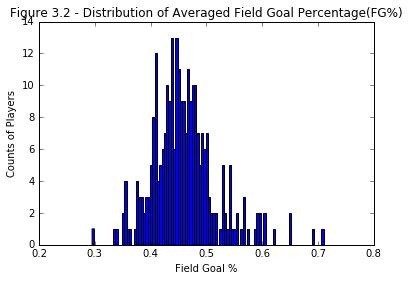

In [170]:
## ------------------------------------ Criteria 2: FG% ----------------------------------------

# FG% for each game of each player
player_game_fg_raw = player_game_group["FGM"].sum() / player_game_group["FGM"].size()
player_game_fg = player_game_fg_raw.reset_index()
player_game_fg.columns.values[2] = "FG%"
print player_game_fg.head()

# average FG% among games for each player 
player_fg = player_game_fg.groupby("player_id")["FG%"].mean().reset_index()
print player_fg.head()

# select top n players by FG%
player_fg_top = player_fg.sort_values(by="FG%", ascending=False).reset_index()
print "\n", "Top %d Players by FG criteria:" % top_number
print player_fg_top.head(int(top_number))

# visualize the distribution of FG% for all the players
plt.hist(player_fg_top["FG%"], bins=100)
plt.title("Figure 3.2 - Distribution of Averaged Field Goal Percentage(FG%)")
plt.xlabel("Field Goal %")
plt.ylabel("Counts of Players")
plt.show()

In [171]:
### ----------------------------  2. Compare Two Versions of Top Lists -------------------------
    # top list by PPG: saved as DataFrame "player_ppg_top"
    # top list by FG%: saved as DataFrame "player_fg_top"

# Extract the Top 5 Players' (by PPG) Ranking under FG% Metrics (the alter_rank starts from 0)
alter_rank_fg = np.array([], dtype="int64")

for player in player_ppg_top["player_id"]:
    rank = player_fg_top[player_fg_top["player_id"] == player].index.values
    alter_rank_fg = np.append(alter_rank_fg,[rank])

player_ppg_top["alter_rank_by_FG"] = alter_rank_fg

print "\n", "Top %d Players by PPG criteria:" % top_number
print player_ppg_top.head(int(top_number))

# Extract the Top 5 Players' (by FG%) Ranking under PPG Metrics (the alter_rank starts from 0)
alter_rank_ppg = np.array([], dtype="int64")

for player in player_fg_top["player_id"]:
    rank = player_ppg_top[player_ppg_top["player_id"] == player].index.values
    alter_rank_ppg = np.append(alter_rank_ppg,[rank])

player_fg_top["alter_rank_by_PPG"] = alter_rank_ppg

print "\n", "Top %d Players by FG criteria:" % top_number
print player_fg_top.head(int(top_number))


Top 5 Players by PPG criteria:
   index  player_id        PTS  alter_rank_by_FG
0     27       2544  19.803922                59
1    132     201939  19.491228                56
2    105     201566  19.444444               149
3     28       2546  18.789474               139
4    187     202691  18.543860               109

Top 5 Players by FG criteria:
   index  player_id       FG%  alter_rank_by_PPG
0    124     201599  0.710055                101
1     13       2199  0.692956                 90
2      6       1889  0.650072                154
3    137     201949  0.649858                 71
4    246     203486  0.622819                 97


We can see from the above chart that the two versions of the Top 5 List varies a lot,
and players who rank high by one criteria don't have high ranking under the other criteria.

In [172]:
### -------------------------------------  3. Visulization --------------------------------------------

## (1) Shot_Distance of Shot_Result_Made and Shot_Result_Missed, for all layers VS top players

    # distance of shot_made, all players
data_shotdist_made = data[data["SHOT_RESULT"] == "made"]["SHOT_DIST"]
     # distance of shot_mmissed, all players
data_shotdist_miss = data[data["SHOT_RESULT"] == "missed"]["SHOT_DIST"]

data_top_ppg = data[data["player_id"].isin(player_ppg_top.head(int(top_number))["player_id"].values)]
    # distance of shot_made, top 5 players by PPG
data_top_ppg_shotdist_made = data_top_ppg[data_top_ppg["SHOT_RESULT"] == "made"]["SHOT_DIST"]
    # distance of shot_missed, top 5 players by PPG
data_top_ppg_shotdist_miss = data_top_ppg[data_top_ppg["SHOT_RESULT"] == "missed"]["SHOT_DIST"]

data_top_fg = data[data["player_id"].isin(player_fg_top.head(int(top_number))["player_id"].values)]
    # distance of shot_made, top 5 players by FG%
data_top_fg_shotdist_made = data_top_fg[data_top_fg["SHOT_RESULT"] == "made"]["SHOT_DIST"]
    # distance of shot_missed, top 5 players by FG%
data_top_fg_shotdist_miss = data_top_fg[data_top_fg["SHOT_RESULT"] == "missed"]["SHOT_DIST"]

Figure 3.3 - The Distribution of Shot Distance:


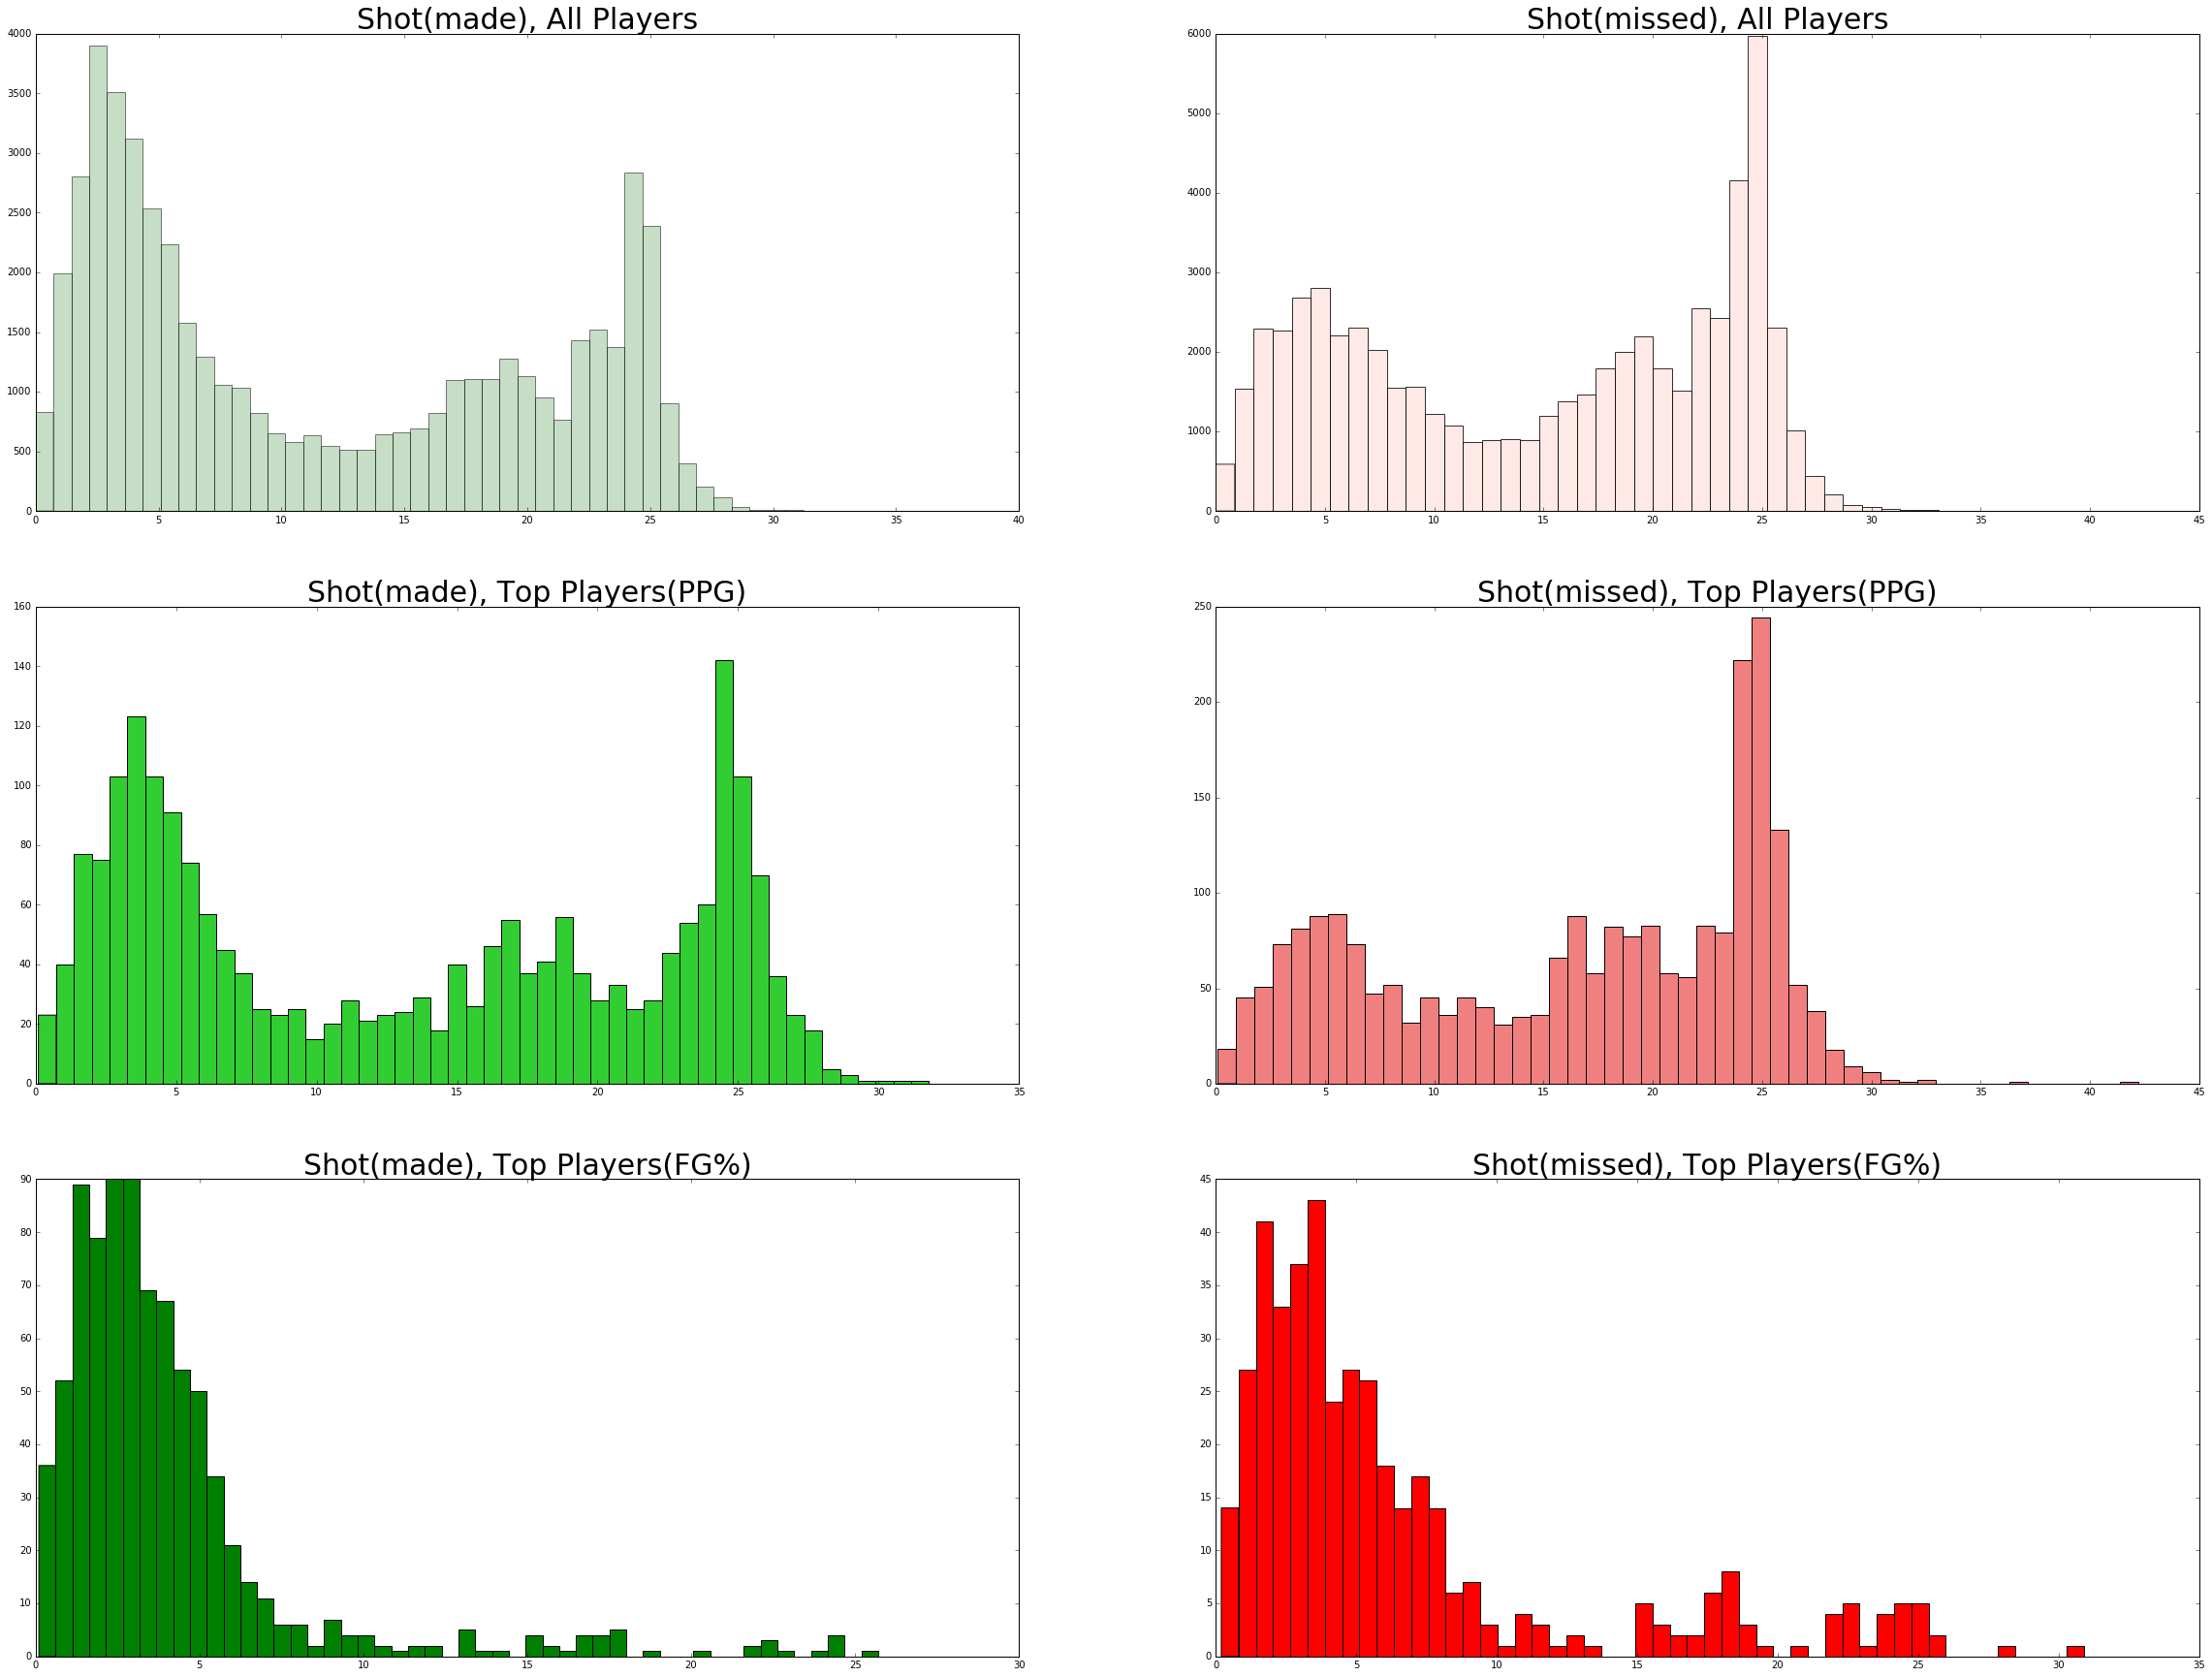

In [173]:
print "Figure 3.3 - The Distribution of Shot Distance:"

fig, ax = plt.subplots(3,2,figsize=(40,30))
ax[0,0].hist(data_shotdist_made, bins=50, color="DarkSeaGreen", alpha=0.5, label="All Players")
ax[0,0].set_title("Shot(made), All Players", fontsize=30)
ax[1,0].hist(data_top_ppg_shotdist_made, bins=50, color="limegreen", label="Top Players by PPG")
ax[1,0].set_title("Shot(made), Top Players(PPG)", fontsize=30)
ax[2,0].hist(data_top_fg_shotdist_made, bins=50, color="green", label="Top Players by FG%")
ax[2,0].set_title("Shot(made), Top Players(FG%)", fontsize=30)

ax[0,1].hist(data_shotdist_miss, bins=50, color="mistyrose", alpha=0.8, label="All Players")
ax[0,1].set_title("Shot(missed), All Players", fontsize=30)
ax[1,1].hist(data_top_ppg_shotdist_miss, bins=50, color="lightcoral", label="Top Players by PPG")
ax[1,1].set_title("Shot(missed), Top Players(PPG)", fontsize=30)
ax[2,1].hist(data_top_fg_shotdist_miss, bins=50, color="red", label="Top Players by FG%")
ax[2,1].set_title("Shot(missed), Top Players(FG%)", fontsize=30)

plt.show()

We can tell from the above visualization that players with high FG% tend to shot from a cloer distance, no matter if the shots are made or missed.

In [174]:
## (2)Number of Game Played, for all layers VS top players

    # number of game played, all players
data_game = data[["player_id","GAME_ID"]].groupby("player_id").size()

    # number of game played, top 5 players by PPG
data_top_ppg_game = data_top_ppg[["player_id","GAME_ID"]].groupby("player_id").size()

    # number of game played, top 5 players by FG%
data_top_fg_game = data_top_fg[["player_id","GAME_ID"]].groupby("player_id").size()

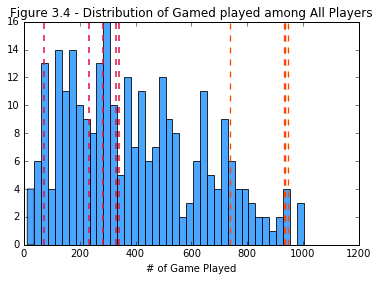

Game Played by the Top Players (PPG), marked by orange:
player_id
2544      933
2546      737
201566    937
201939    935
202691    947
dtype: int64 

Game Played by the Top Players (FG%), marked by red:
player_id
1889       71
2199      282
201599    329
201949    234
203486    339
dtype: int64


In [175]:
plt.hist(data_game, bins=40, color="dodgerblue", alpha=0.8)
plt.title("Figure 3.4 - Distribution of Gamed played among All Players")
plt.xlabel("# of Game Played")
for i in data_top_ppg_game:
    plt.axvline(i, lw=1.3, ls="--", color="orangered")
for i in data_top_fg_game:
    plt.axvline(i, lw=1.5, ls="--", color="crimson")
plt.show()

print "Game Played by the Top Players (PPG), marked by orange:"
print data_top_ppg_game, "\n"

print "Game Played by the Top Players (FG%), marked by red:"
print data_top_fg_game

We can see that the Top 5 Player (by FG%) don't play many games in general.

In [176]:
## (3)FGM (field goal make) per Game, for all layers VS top players (optional)
    # average FGM for all the players
player_game_fgm = player_game_group["FGM"].sum().reset_index()
player_fgm = player_game_fgm.groupby(["player_id"])["FGM"].mean().reset_index()

    # average FGM for top players (by PPG)
player_top_ppg_fgm = player_fgm[player_fgm["player_id"].isin(player_ppg_top.head(int(top_number))["player_id"].values)]

    # average FGM for top players (by FG%)
player_top_fg_fgm = player_fgm[player_fgm["player_id"].isin(player_fg_top.head(int(top_number))["player_id"].values)]

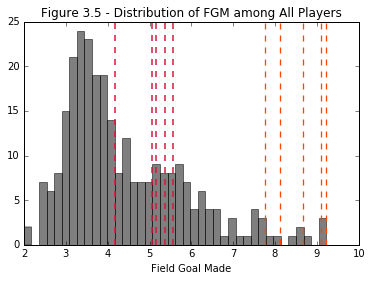

Average FGM for top players (by PPG), marked by orange:
     player_id       FGM
27        2544  9.098039
28        2546  8.657895
105     201566  9.222222
132     201939  8.122807
187     202691  7.754386 

Average FGM for top players (by FG%), marked by red:
     player_id       FGM
6         1889  4.181818
13        2199  5.361111
124     201599  5.065217
137     201949  5.555556
246     203486  5.146341


In [177]:
plt.hist(player_fgm["FGM"], bins=40, color="black", alpha=0.5)
plt.title("Figure 3.5 - Distribution of FGM among All Players")
plt.xlabel("Field Goal Made")
for i in player_top_ppg_fgm["FGM"]:
    plt.axvline(i, lw=1.3, ls="--", color="orangered")
for i in player_top_fg_fgm["FGM"]:
    plt.axvline(i, lw=1.5, ls="--", color="crimson")
plt.show()

print "Average FGM for top players (by PPG), marked by orange:"
print player_top_ppg_fgm,"\n"

print "Average FGM for top players (by FG%), marked by red:"
print player_top_fg_fgm

In [178]:
## (4)FGA (field goal attempted) per Game, for all layers VS top players (optional)

    # average FGA for all the players
player_game_fga = player_game_group["FGM"].size().reset_index()
player_game_fga.columns.values[2] = "FGA"
player_fga = player_game_fga.groupby(["player_id"])["FGA"].mean().reset_index()

    # average FGA for top players (by PPG)
player_top_ppg_fga = player_fga[player_fga["player_id"].isin(player_ppg_top.head(int(top_number))["player_id"].values)]

    # average FGA for top players (by FG%)
player_top_fg_fga = player_fga[player_fga["player_id"].isin(player_fg_top.head(int(top_number))["player_id"].values)]

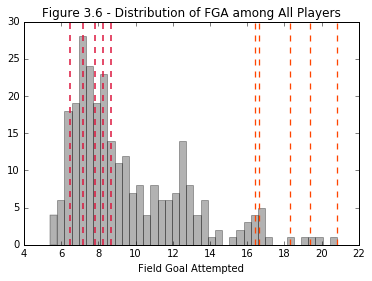

Average FGA for top players (by PPG), marked by orange:
     player_id        FGA
27        2544  18.294118
28        2546  19.394737
105     201566  20.822222
132     201939  16.403509
187     202691  16.614035 

Average FGA for top players (by FG%), marked by red:
     player_id       FGA
6         1889  6.454545
13        2199  7.833333
124     201599  7.152174
137     201949  8.666667
246     203486  8.268293


In [179]:
plt.hist(player_fga["FGA"], bins=40, color="black", alpha=0.3)
plt.title("Figure 3.6 - Distribution of FGA among All Players")
plt.xlabel("Field Goal Attempted")
for i in player_top_ppg_fga["FGA"]:
    plt.axvline(i, lw=1.3, ls="--", color="orangered")
for i in player_top_fg_fga["FGA"]:
    plt.axvline(i, lw=1.5, ls="--", color="crimson")
plt.show()

print "Average FGA for top players (by PPG), marked by orange:"
print player_top_ppg_fga,"\n"

print "Average FGA for top players (by FG%), marked by red:"
print player_top_fg_fga

We can see from the two visualizations above: top players (by FG%) temp to make less FGA and also FGM; while top players (by PPG) top at these two metrics.

# Milestone 4 - Simple Streak Metric

For the top 5 players, analyze how well the streak of made and missed shots can predict whether the player makes a shot ('FGM')

Top 5 Players by PPG criteria:

   index  player_id        PTS

0     27       2544  19.803922

1    132     201939  19.491228

2    105     201566  19.444444

3     28       2546  18.789474

4    187     202691  18.543860

In [180]:
#top5_player_id = [2544, 201939, 201566, 2546, 202691]

#FGM in dataset takes value 1.0 if SHOT_RESULT is 'made' and 0.0 if SHOT_RESULT is 'missed'
top5_subset_data = final_df2[(final_df2.player_id == 2544) | (final_df2.player_id == 201939) |
                            (final_df2.player_id == 201566) | (final_df2.player_id == 2546) |
                            (final_df2.player_id == 202691)]

top5_subset_data['streak_metric'] = top5_subset_data['MAKE_STREAK'].values - top5_subset_data['MISS_STREAK'].values

top5_subset_data.head(4)

/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,GAME_ID,LOCATION,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,SHOT_RESULT,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id,shot_series_length,MAKE_STREAK,MISS_STREAK,streak_metric
1161,21400010.0,H,1.0,1.0,585.0,2.8,18.7,made,2399.0,5.4,1.0,2.0,2546.0,13.0,2.0,0.0,2.0
1162,21400010.0,H,2.0,1.0,509.0,9.2,22.0,missed,2399.0,4.0,0.0,0.0,2546.0,13.0,0.0,1.0,-1.0
1163,21400010.0,H,3.0,1.0,439.0,5.3,6.1,missed,2399.0,1.7,0.0,0.0,2546.0,13.0,0.0,2.0,-2.0
1164,21400010.0,H,4.0,2.0,412.0,22.9,12.6,made,201959.0,4.4,1.0,2.0,2546.0,13.0,1.0,0.0,1.0


In [181]:
print 'max make_streak value:', np.amax(top5_subset_data['MAKE_STREAK'].values)
print 'max miss_streak value:', np.amax(top5_subset_data['MISS_STREAK'].values)

max make_streak value: 13.0
max miss_streak value: 9.0


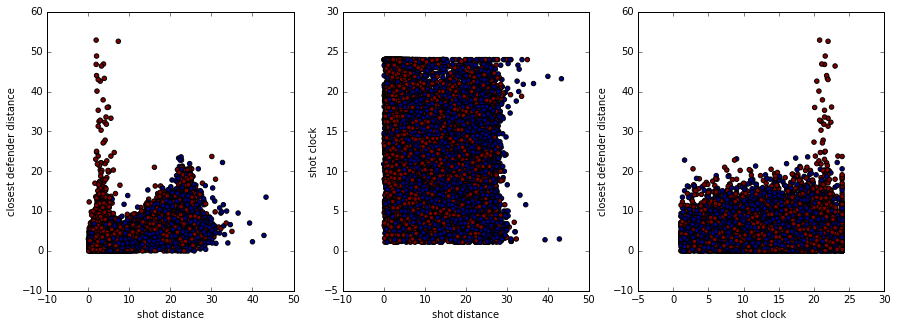

In [182]:
#plt.scatter(x_test, lr.predict(x_test), c='blue')

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].scatter(x_test['SHOT_DIST'], x_test['CLOSE_DEF_DIST'], c=y_test)
ax[0].set_xlabel('shot distance')
ax[0].set_ylabel('closest defender distance')

ax[1].scatter(x_test['SHOT_DIST'], x_test['SHOT_CLOCK'], c=y_test)
ax[1].set_xlabel('shot distance')
ax[1].set_ylabel('shot clock')

ax[2].scatter(x_test['SHOT_CLOCK'], x_test['CLOSE_DEF_DIST'], c=y_test)
ax[2].set_xlabel('shot clock')
ax[2].set_ylabel('closest defender distance')

In [203]:
# fit logreg with full dataset

response = final_df2['FGM'].values
predictors = final_df2[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']]

x_train, x_test, y_train, y_test = sk_split(predictors, response, test_size=0.33)

lr = LogReg()
lr.fit(x_train, y_train)
print 'classification score:', lr.score(x_test, y_test)

classification score: 0.601754101023


In [189]:
# compare prediction by logreg of whether or not shot is made for home vs away games

### home
response = final_df2[final_df2.LOCATION == 'H']['FGM']
predictors = final_df2[final_df2.LOCATION == 'H'][['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']]

x_train, x_test, y_train, y_test = sk_split(predictors, response, test_size=0.33)

lr = LogReg()
lr.fit(x_train, y_train)
print 'classification score for home games:', lr.score(x_test, y_test)

### away
response = final_df2[final_df2.LOCATION == 'A']['FGM']
predictors = final_df2[final_df2.LOCATION == 'A'][['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']]

x_train, x_test, y_train, y_test = sk_split(predictors, response, test_size=0.33)

lr = LogReg()
lr.fit(x_train, y_train)
print 'classification score for away games:', lr.score(x_test, y_test)

classification score for home games: 0.597238017872
classification score for away games: 0.604232059747


In [205]:
#lr.fit model to entire dataset before running this
# examine the max make_streak value (make_streak = 13) - game_ID=21400651, player_Id = 202691

subset = top5_subset_data[(top5_subset_data.GAME_ID == 21400651) & (top5_subset_data.player_id == 202691)]
subset.shape
lr.score(subset[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], subset['FGM'])

0.47999999999999998

Using basic predictors shot_clock, shot_dist, and close_def_dist, which are decent representative markers of shot difficulty, logistic regression correctly predicts whether a shot is made or missed roughly 60% of the time. There is no significant difference between prediction of shots made at home vs away games. Looking at the most successful make_streak of 13 shots made in a row by a top5 player (selected by most points per game ie PPG), the model trained to the entire dataaset by cross validation only results in a score of 0.48, meaning that based on the broader training set for this particular streak more that half the shots that were made were expected to be missed by the trained model. 

# Milestone 5 - Future Directions

Using the streak metrics that we created in the above analysis, we want to further stratify the shot records by the following three factors, and see how they would affect the hot hand theory. We would describe the analysis plans in the following, which are still quite flexible, and feedback or suggestions from the TF are welcome.
1.  Home v Away Games
Under the hypothesis that players are easier to “get hot” when playing at home, we want to separately look at each player’s streak metrics for home games (location=H) and away games (location=A) and compare the statistics in the two conditions. We looked at this at a global level already and saw no difference in logistic regression's ability to predict whether or not a shot is made using the three basic predictors (shot distance, defender distance, shot clock) between home and away games.  
The specific analysis plan: we could always compare the averaged home and averaged away metrics for each players, and do the paired statistical test (for example: paired t-test) to examine if there are significant differences between “home metrics” and “away metrics”; and we could plot the distribution of home and away metrics of all the games for all the players and visualize the difference.
2.  Top Players
We created two versions of ranking among players by two standard: PPG or FG%. And we want to test the hypothesis that top players are easier to “get hot”.
For now we want to draw the threshold of “top players” at top 5, and compare the streak metrics of the top five players to the rest of the players. Also it would be interesting to see if the results are different for the two versions of the ranking system, as we do see differences between the two in the exploratory analysis. Furthermore , we could stratify the players into groups by performance (for example: top 1/3, middle 1/3 and bottom 1/3 players) and examine the streak metrics among different groups.
We have started our analysis by looking at the top 5 players (by PPG) using logistic regression to predict whether or not the shot is made.
3.  Defenders
We hypothesize that certain defenders are better at stopping the “hot-hand” trend. To test this hypothesis, we want to identify the closest defender (by defender ID) when the streak direction is reversed, and draw a distribution to see if there are enrichments on certain defenders. If their shot records are available as well, we can further examine the relationship between good defenders and hot-hands.
4.  Combined Model
If we see differences in streak metrics for home games, or top players, or defenders, or other factors that we would test, we could ultimately build a prediction model to show if specific players would get hot for this specific game. For example, if using the three factors described above, the model would have a binary predictor of “game location” (A/H), a binary predictor of  “top players (T/F)” (or a numerical predictor of “rank”), and a binary predictor of “if certain defenders are present in the game (T/F)”. We could start from simple logistic regression to more complex model such as decision tree.
